# Problem Set 8
## Nora Nickels
### Perspectives of Computational Modeling
### Winter 2018

## Problem 1: Neural Network Horse Race

In [1]:
# Import packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib notebook
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [2]:
# Import the strongdrink data.

strongdrink = pd.read_csv("strongdrink.txt")
strongdrink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 1a) Scatterplot

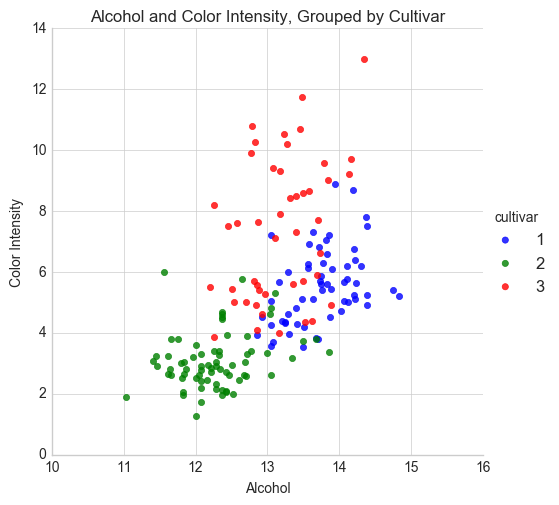

In [3]:
# Use seaborn to create scatterplot, grouped by cultivar.

sb.lmplot(x='alco', y='color_int', data = strongdrink, fit_reg = False, hue = 'cultivar')
plt.xlabel(r'Alcohol')
plt.ylabel(r'Color Intensity')
plt.title('Alcohol and Color Intensity, Grouped by Cultivar')
plt.show()

### 1b) Multinomial logistic model using k-fold cross validation

In [5]:
import sklearn
from pandas import Series, DataFrame
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error

In [6]:
# Define X and y variables for models.

X = strongdrink[['alco', 'malic', 'tot_phen', 'color_int']].values
y = strongdrink[['cultivar']].values.ravel()

In [43]:
# Define k-fold cross validation with k = 4 folds

k = 4
clf_mlog = KFold(n_splits=k, random_state=22, shuffle=True)
clf_mlog.get_n_splits(X)

4

In [46]:
# Define vectors that are k elements long of MSE's.

MSE_vec_kf = np.zeros(k)

# Test model performance with k-fold cross validation

k_ind = int(0)
for train_index, test_index in clf_mlog.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train_k, X_test_k = X[train_index], X[test_index]
    y_train_k, y_test_k = y[train_index], y[test_index]
    MultLogReg_k = LogisticRegression(multi_class='multinomial', solver='newton-cg', C = 0.3)
    MultLogReg_k.fit(X_train_k, y_train_k)
    y_pred_k = MultLogReg_k.predict(X_test_k)
    MSE_vec_kf[k_ind] = ((y_test_k - y_pred_k) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1
    
# Calculate overll MSE

MSE_kf = MSE_vec_kf.mean()
print('test estimate MSE k-fold=', MSE_kf)

k index= 0
MSE for test set 0  is 0.0454545454545
k index= 1
MSE for test set 1  is 0.0454545454545
k index= 2
MSE for test set 2  is 0.0681818181818
k index= 3
MSE for test set 3  is 0.113636363636
test estimate MSE k-fold= 0.0681818181818


### 1b Report
* The tuning parameter of penalty could not be adjusted, as the ‘newton-cg’ solver only supports only 12 penalties.
* After playing with the tuning parameter value of C, which can be adjusted as a positive values, the lowest possible MSE was obtained with a C of 0.3. A smaller C specifies stronger regularization.
* Therefore:
* penalty = 12
* C = 0.3
* Minimized overall MSE = 0.0681818181818

### 1c) Random forest classifier model using OOB cross validation

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [10]:
# Fit a random forest model of cultivar

rfc = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=7, bootstrap=True, oob_score=True, random_state=22)

rfc.fit(X, y)

# Get the MSE based on the OOB score

MSE_rfc = 1 - rfc.oob_score_
print(MSE_rfc)

0.0681818181818


### 1c Report
* The tuning parameters of n_estimators, max_depth, and min_samples_leaf were adjusted.
* The lowest MSE that could be found was the same as the lowest MSE from part b.
* Therefore:
* n_estimators = 100
* max_depth = 4
* min_samples_leaf = 7
* Minimized overall MSE = 0.0681818181818

### 1d) Support vector machines model with Gaussian radial basis function kernel using k-fold cross validation

In [11]:
from sklearn.svm import SVC

In [12]:
# Define k-fold cross validation with k = 4 folds

k = 4
clf_svm = KFold(n_splits=k, random_state=22, shuffle=True)
clf_svm.get_n_splits(X)

4

In [13]:
# Define vectors that are k elements long of MSE's.

MSE_vec_svm = np.zeros(k)

# Test model performance with k-fold cross validation, rbf kernel, and svm model

k_ind = int(0)
for train_index, test_index in clf_svm.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svc = SVC(kernel='rbf', gamma = 1.7, C = 1)
    svc.fit(X_train, y_train)
    y_pred_svc = svc.predict(X_test)
    MSE_vec_svm[k_ind] = ((y_test - y_pred_svc) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_svm[k_ind])
    k_ind += 1
    
# Calculate overll MSE

MSE_svm = MSE_vec_svm.mean()
print('test estimate MSE k-fold=', MSE_svm)

k index= 0
MSE for test set 0  is 0.0
k index= 1
MSE for test set 1  is 0.0681818181818
k index= 2
MSE for test set 2  is 0.0454545454545
k index= 3
MSE for test set 3  is 0.0681818181818
test estimate MSE k-fold= 0.0454545454545


### 1d Report
* The tuning parameters of C and gamma were adjusted
* The lowest MSE that could be found was lower than the lowest MSE found for parts 1b and 1c.
* Therefore:
* C = 1
* gamma = 1.7
* Minimized overall MSE = 0.0454545454545

### 1e) Neural network MLP Classifier model using k-fold cross validation

In [14]:
from sklearn.neural_network import MLPClassifier

In [52]:
# Define k-fold cross validation with k = 4 folds

k = 4
clf_mlp = KFold(n_splits=k, random_state=22, shuffle=True)
clf_mlp.get_n_splits(X)

4

In [93]:
# Define vectors that are k elements long of MSE's.

MSE_vec_mlp = np.zeros(k)

# Test model performance with k-fold cross validation, rbf kernel, and svm model

k_ind = int(0)
for train_index, test_index in clf_mlp.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train_mlp, X_test_mlp = X[train_index], X[test_index]
    y_train_mlp, y_test_mlp = y[train_index], y[test_index]
    mlp = MLPClassifier(activation = 'relu', solver = 'lbfgs', alpha = 1, hidden_layer_sizes = 100)
    mlp.fit(X_train_mlp, y_train_mlp)
    y_pred_mlp = mlp.predict(X_test_mlp)
    MSE_vec_mlp[k_ind] = ((y_test_mlp - y_pred_mlp) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_mlp[k_ind])
    k_ind += 1
    
# Calculate overll MSE

MSE_mlp = MSE_vec_mlp.mean()
print('MSE_mlp', MSE_mlp)

k index= 0
MSE for test set 0  is 0.0454545454545
k index= 1
MSE for test set 1  is 0.0909090909091
k index= 2
MSE for test set 2  is 0.0454545454545
k index= 3
MSE for test set 3  is 0.0909090909091
MSE_mlp 0.0681818181818


### 1e Report
* The tuning parameters of alpha, hidden_layer_sizes, and activation were adjusted.
* The lowest MSE that could be found was 0.03 - 0.05, but I couldn't repeat these results after continue to play with the parameters.
* Therefore, the lowest MSE I could repeat as shown above, was with the following set parameters:
* activation = relu
* hidden_layer_sizes = 100
* alpha = 1
* Minimized overall MSE = 0.0681818181818

## 1f) Which of the above models is the best predictor of cultivar and why?

Of the four models, the support vector machine model consistently gave the lowest MSE's' overall. The neural network MLP model did give low MSE's, but this model changed drastically based on the changing of its parameters, and also changed even when the same parameters were used. This led to a lot of unreliable results (and frustration when I couldn't get the low MSE I had been able to get previoiusly!!). At one point I had an MSE as low as 0.03 - 0.05, but I couldn't repeat the conditions to replicate the output. The logistic regression and random forest models never got as low as support vector machine and neural network, so I would say that both the support vector machines and neural network models are best.